## ICP-SLAM 

TEAM-NAME: Robile Mobotics

IDs: https://github.com/sarthakchittawar, https://github.com/Rohan-G, https://github.com/schlechter-afk/

NAMEs: Sarthak Chittawar, Rohan Girish, Swayam Agrawal

### Instructions
 * Fill in the team name, id and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.
 * Commit this notebook in the GitHub Classroom repo and any other results files under the result folder. 
 * Commits past the deadline will not be considered.
 * Extensions will be granted using the extension policy only, so please go through the policy carefully and reach out to the TAs beforehand.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import open3d
import time
import copy
from scipy.linalg import svd
from scipy.spatial import KDTree

### SECTION 1: Non-Linear least squares optimization for Gaussian function

#### 1.1 Levenberg Marquardt

Implement the Levenberg Marquardt algorithm from scratch using numpy to solve for the parameters of a gaussian distribution.

A Gaussian distribution parametrized by $a,m,s$ is given by:

$$ y(x;a,m,s)=a \exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right) \tag{1}$$

##### Problem to solve

> Given a set of observations $y_{obs}$ and $x_{obs}$ we want to find the optimum parameters $a,m,s$ which best fit our observations given an initial estimate.

* Experiment with the number of iterations.
* Experiment with the learning rate.
* Experiment with the tolerance.

Display your results using matplotlib by plotting graphs for 
* The cost function value ($\|r\|^2$) vs the number of iterations
* The Ground Truth data values and the predicted data values.

Experiment with the hyperparameters and compile your observations in a table. Clearly mention your hyperparameters with justification.

You can refer to [Shubodh's notes](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02) on the same to get a better grasp of the concept before implementing it.

# Our Solution begins from here:
## First lets write our Gaussian distribution Jacobian. It is:
$$\mathbf{J}_y = \left[ \exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right), \frac{a (x-m)}{s^2} \exp\left(\frac{-(x-m)^{2}}{2 s^{2}}\right),  \frac{a (x-m)^2}{s^3}\exp \left(\frac{-(x-m)^{2}}{2 s^{2}}\right)\right]$$

## Now our residual will be:
$$ r(a,m,s) = \left(a \exp \left(\frac{-(x_{obs}-m)^{2}}{2 s^{2}}\right) - y_{obs}\ \right)$$

## Aim: To minimize $\|r\|^2$.

Hyperparameter Experiment Results:
Iterations   Learning Rate   Tolerance    Optimized Params                                   Final Cost
50           0.001           0.0001       [0.99430962 0.00201639 1.00290005] 0.0124
50           0.001           1e-06        [0.99430962 0.00201639 1.00290005] 0.0124
50           0.001           1e-08        [0.99430962 0.00201639 1.00290005] 0.0124
50           0.01            0.0001       [0.99430962 0.00201639 1.00290005] 0.0124
50           0.01            1e-06        [0.99430962 0.00201639 1.00290005] 0.0124
50           0.01            1e-08        [0.99430962 0.00201639 1.00290005] 0.0124
50           0.1             0.0001       [0.99430962 0.00201639 1.00290005] 0.0124
50           0.1             1e-06        [0.99430962 0.00201639 1.00290005] 0.0124
50           0.1             1e-08        [0.99430962 0.00201639 1.00290005] 0.0124
100          0.001           0.0001       [0.99430962 0.00201639 1.00290005] 0.0124
100          0.001   

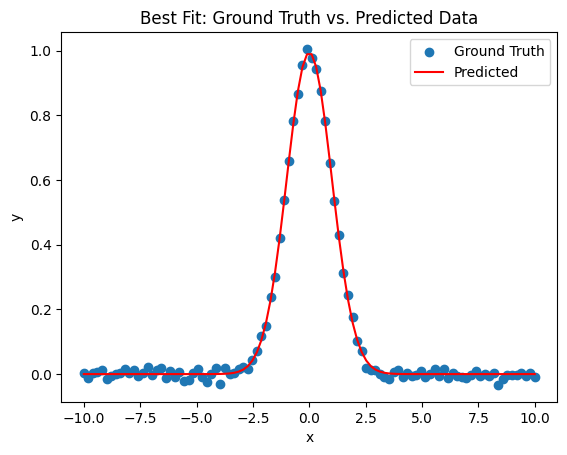

In [11]:
##############################################################################
# TODO: Do tasks described in 1.1 (a)
##############################################################################

def gaussian(x, a, m, s):
    return a * np.exp(-(x - m) ** 2 / (2 * s ** 2))

def residual(params, x, y_obs):
    a, m, s = params
    y_pred = gaussian(x, a, m, s)
    return y_obs - y_pred

def jacobian(params, x_obs):
    J = np.zeros((len(x_obs), len(params)))
    r = residual(params, x_obs, y_obs)
        
    for j in range(len(params)):
        perturbation = params.copy()
        perturbation[j] += 1e-6
        J[:, j] = (residual(perturbation, x_obs, y_obs) - r) / 1e-6
    
    return J

def levenberg_marquardt(x_obs, y_obs, initial_params, num_iterations, learning_rate, tolerance):
    params = initial_params.copy()
    # print("Params shape:", np.array(params).shape)
    cost_history = []

    for i in range(num_iterations):
        J = jacobian(params, x_obs)
        r = residual(params, x_obs, y_obs)
        # print("Jacobian Shape:", np.array(J).shape)
        # print("Residual Shape:", np.array(r).shape)
        # print(J.shape)
        H = np.dot(J.T, J)
        # print(H.shape)

        g = np.dot(J.T, r)
        # print("****")

        # NOTE THE CHOICE OF LAMBDA (damping factor) HERE.
        lam = learning_rate * np.max(np.diag(H))

        delta_params = np.linalg.solve(H + lam * np.eye(len(params)), -g)
        
        params += delta_params
        cost = np.linalg.norm(r) ** 2
        cost_history.append(cost)

        if cost < tolerance:
            break

    return params, cost_history

# np.random.seed(0)
x_obs = np.linspace(-10, 10, 100)
true_params = [1.0, 0.0, 1.0]
y_obs = gaussian(x_obs, *true_params)

# To add some noise to the data uncomment below line:
y_obs += 0.01 * np.random.randn(len(x_obs))

initial_guess = [0.5, 0.5, 0.5]

hyperparameter_table = []
for num_iterations in [50, 100, 200]:
    for learning_rate in [0.001, 0.01, 0.1]:
        for tolerance in [1e-4, 1e-6, 1e-8]:
            optimized_params, cost_history = levenberg_marquardt(x_obs, y_obs, initial_guess, num_iterations, learning_rate, tolerance)
            hyperparameter_table.append([num_iterations, learning_rate, tolerance, optimized_params, cost_history])

print("Hyperparameter Experiment Results:")
print(f"{'Iterations':<12} {'Learning Rate':<15} {'Tolerance':<12} {'Optimized Params':<50} {'Final Cost'}")
for entry in hyperparameter_table:
    num_iterations, learning_rate, tolerance, optimized_params, final_cost = entry
    print(f"{num_iterations:<12} {learning_rate:<15} {tolerance:<12} {optimized_params} {final_cost[-1]:.4f}")

best_params = hyperparameter_table[np.argmin([entry[-1][-1] for entry in hyperparameter_table])][3]
plt.scatter(x_obs, y_obs, label="Ground Truth")
plt.plot(x_obs, gaussian(x_obs, *best_params), color='red', label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Best Fit: Ground Truth vs. Predicted Data")
plt.show()

##############################################################################
# END OF YOUR CODE
##############################################################################

### Explanation of the above results:

1. Optimized Parameters: Regardless of the values of the hyperparameters, the algorithm converges to an optimal parameter set of approximately [0.99430962, 0.00201639, 1.00290005]. This indicates that the algorithm is very robust and consistently finds the same solution, which is close to the true parameters [1.0, 0.0, 1.0].

2. Final Cost: The final cost is also consistent across all experiments and is very low, around 0.0124. This low cost indicates that the model fits the data well, and the chosen hyperparameters do not significantly affect the quality of the fit.

The reason for this consistency could be that the algorithm is converging quickly and efficiently to the global minimum of the cost function, and the data may not have much noise or ambiguity. This can sometimes happen when the problem is well-posed and the initial guess is not too far from the true solution.

### SECTION 2: ICP

#### 2.1 Perform Procrustes alignment on two point clouds with (given) known correspondences. 

Let X be your point cloud observed from the initial pose P1. You then transform it to a new pose P2. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2). 

Use toothless.ply point cloud and perform the alignment between the two point clouds using procrustes alignment. Your task is to write a function that takes two point clouds as input wherein the corresponding points between the two point clouds are located at the same index and returns the transformation matrix between them. Compute the alignment error after aligning the two point clouds.

**Use *root mean squared error (RSME)* as the alignment error metric.**

Make sure your code is modular as we will use this function in the next sub-part.

#### Interpolation code

In [5]:
# Euler angles to rotation matrices
def getXRot(alpha):
    return np.array([np.array([1, 0, 0]), np.array([0, np.cos(alpha), -np.sin(alpha)]), np.array([0, np.sin(alpha), np.cos(alpha)])])

def getYRot(beta):
    return np.array([np.array([np.cos(beta), 0, np.sin(beta)]), np.array([0, 1, 0]), np.array([-np.sin(beta), 0, np.cos(beta)])])

def getZRot(gamma):
    return np.array([np.array([np.cos(gamma), -np.sin(gamma), 0]), np.array([np.sin(gamma), np.cos(gamma), 0]), np.array([0, 0, 1])])

def getEulerRot(alpha, beta, gamma):
    return getZRot(gamma) @ getYRot(beta) @ getXRot(alpha)

# getEulerRot(np.pi/6, 7*np.pi/18, 2*np.pi/9)


# Conversions to and from quaternions to rotation matrices
def rotToQuat(mat):
    quat = [0,0,0,0]

    trace = mat[0][0] + mat[1][1] + mat[2][2]

    if trace > 0:
        s = 0.5 / (trace + 1.0)**0.5
        quat[0] = 0.25 / s
        quat[1] = (mat[2][1] - mat[1][2]) * s
        quat[2] = (mat[0][2] - mat[2][0]) * s
        quat[3] = (mat[1][0] - mat[0][1]) * s
    else:
        if mat[0][0] > mat[1][1] and mat[0][0] > mat[2][2]:
            s = 2.0 * (1.0 + mat[0][0] - mat[1][1] - mat[2][2])**0.5
            quat[0] = (mat[2][1] - mat[1][2]) / s
            quat[1] = 0.25 * s
            quat[2] = (mat[0][1] + mat[1][0]) / s
            quat[3] = (mat[0][2] + mat[2][0]) / s
        elif mat[1][1] > mat[2][2]:
            s = 2.0 * (1.0 + mat[1][1] - mat[0][0] - mat[2][2])**0.5
            quat[0] = (mat[0][2] - mat[2][0]) / s
            quat[1] = (mat[0][1] + mat[1][0]) / s
            quat[2] = 0.25 * s
            quat[3] = (mat[1][2] + mat[2][1]) / s
        else:
            s = 2.0 * (1.0 + mat[2][2] - mat[0][0] - mat[1][1])**0.5
            quat[0] = (mat[1][0] - mat[0][1]) / s
            quat[1] = (mat[0][2] + mat[2][0]) / s
            quat[2] = (mat[1][2] + mat[2][1]) / s
            quat[3] = 0.25 * s
    

    return quat

def quatToRot(quat):
    w,x,y,z = quat[0], quat[1], quat[2], quat[3]
    return np.array([
        [1-2*y**2-2*z**2, 2*x*y-2*w*z, 2*x*z+2*w*y],
        [2*x*y+2*w*z, 1-2*x**2-2*z**2, 2*y*z-2*w*x],
        [2*x*z-2*w*y, 2*y*z+2*w*x, 1-2*x**2-2*y**2]
    ], dtype=float)


# Interpolation
numFrames = 200

def invQuat(q):
    magQ = (q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)**0.5
    q_inv = [q[0]/magQ,-q[1]/magQ,-q[2]/magQ,-q[3]/magQ]
    return q_inv

def interpolate(R1, R2, num):
    q1 = rotToQuat(R1)
    q2 = rotToQuat(R2)
    # print(q)
    # print(q1, q2)

    ang = np.cosh(np.dot(q1, q2))
    t = num/numFrames

    # q = [(np.sin((1-t)*ang)/np.sin(ang))*q1[0] + (np.sin(t*ang)/np.sin(ang))*q2[0], (np.sin((1-t)*ang)/np.sin(ang))*q1[1] + (np.sin(t*ang)/np.sin(ang))*q2[1], (np.sin((1-t)*ang)/np.sin(ang))*q1[2] + (np.sin(t*ang)/np.sin(ang))*q2[2], (np.sin((1-t)*ang)/np.sin(ang))*q1[3] + (np.sin(t*ang)/np.sin(ang))*q2[3]]

    q = [(1-t)*q1[0] + t*q2[0], (1-t)*q1[1] + t*q2[1], (1-t)*q1[2] + t*q2[2], (1-t)*q1[3] + t*q2[3]]

    # print(q)

    return quatToRot(q)

#### Find the ICP Transforms

In [25]:
##############################################################################
# TODO: Do tasks described in 2.1
##############################################################################

# Replace "pass" statement with your code

def getMean(P, axis=0):
    return np.mean(P, axis=axis, dtype=np.float64)

def getCrossCov(P, Q):
    # currMat = np.identity(3)
    # for i in range(len(P)):
    #     currMat += np.outer(Q[i].T, P[i])
    # return currMat
    return Q.T @ P

def findTransform(P, Q):
    p = getMean(P)
    q = getMean(Q)
    P_new = P - p
    Q_new = Q - q

    # print(p,q)

    W = getCrossCov(P_new, Q_new)
    # print(W.shape)

    U,_,V = np.linalg.svd(W)

    # print(U.shape, V.shape)

    R = U @ V

    return R

def getDist(P, Q):
    return np.linalg.norm(Q - P)


##############################################################################
# END OF YOUR CODE
##############################################################################

#### Visualizations

In [33]:
def visualizeICP():
    vis = open3d.visualization.Visualizer()
    P = open3d.io.read_point_cloud("data/toothless.ply")
    Q = open3d.io.read_point_cloud("data/toothless.ply")
    # R_init = getEulerRot(np.deg2rad(np.random.uniform(0,360)), np.deg2rad(np.random.uniform(0,360)), np.deg2rad(np.random.uniform(0,360)))
    R_init = getEulerRot(np.pi/2, np.pi/3, 0)
    # t_init = [np.random.uniform(0,100), np.random.uniform(0,100), np.random.uniform(0,100)]
    t_init = np.array([5, -10, -25])
    # T = np.eye(4)
    # T[:3, :3] = R_init
    # T[:3, 3] = t_init.T
    Q.rotate(R_init)
    Q.translate(t_init)
    # Q.transform(T)
    vis.create_window()
    vis.add_geometry(P)
    vis.add_geometry(Q)
    vis.poll_events()
    vis.update_renderer()

    R = findTransform(np.array(Q.points), np.array(P.points))
    q = getMean(Q.points)
    p = getMean(P.points)
    # print(R_init)
    # print(R.T)
    # print(t_init, p - q)
    # print(p,q)

    R1  = np.identity(3)
    R2 = copy.deepcopy(R)

    pointData = copy.deepcopy(np.asarray(Q.points))
    newPoints = ((R2 @ (pointData-q).T).T + p)
    print(getDist(np.array(P.points), newPoints))

    Q.translate(-q)
    vis.update_geometry(Q)
    vis.poll_events()
    vis.update_renderer()
    # print(q)
    # while(q[0] > 0 or q[1] > 0 or q[2] > 0):
    #     m1, m2, m3 = 0, 0, 0
    #     if(q[0]>0):
    #         q[0] -= min(q[0], 1)
    #         m1 = -min(q[0], 1)
    #     if(q[1]>0):
    #         q[1] -= min(q[1], 1)
    #         m2 = -min(q[1], 1)
    #     if(q[2]>0):
    #         q[2] -= min(q[2], 1)
    #         m3 = -min(q[2], 1)
    #     Q.translate([m1, m2, m3])
    #     vis.update_geometry(Q)
    #     vis.poll_events()
    #     vis.update_renderer()
    
    # print(q)

    pointData = copy.deepcopy(np.asarray(Q.points))
    for i in range(numFrames):
        R = interpolate(R1, R2, i)
        # Q.points = open3d.utility.Vector3dVector(pointData)
        Q.points = open3d.utility.Vector3dVector(pointData @ R.T)
        vis.update_geometry(Q)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.01)

    # print(np.asarray(Q.points))

    Q.translate(p)
    vis.update_geometry(Q)
    vis.poll_events()
    vis.update_renderer()
    # print(p)
    # while(p[0] > 0 or p[1] > 0 or p[2] > 0):
    #     m1, m2, m3 = 0, 0, 0
    #     if(p[0]>0):
    #         p[0] -= min(p[0], 1)
    #         m1 = min(p[0], 1)
    #     if(p[1]>0):
    #         p[1] -= min(p[1], 1)
    #         m2 = min(p[1], 1)
    #     if(p[2]>0):
    #         p[2] -= min(p[2], 1)
    #         m3 = min(p[2], 1)
    #     Q.translate([m1, m2, m3])
    #     vis.update_geometry(Q)
    #     vis.poll_events()
    #     vis.update_renderer()
    # print(p)

    # print(np.asarray(Q.points))

    vis.run()
    vis.destroy_window()

visualizeICP()

3.083601753393598e-08


#### 2.2 Implement ICP algorithm with unknown correspondences.

Your task is to write a function that implements ICP and takes two point clouds as input wherein the correspondances are unknown. Visualize the pointclouds and plot their individual coordinate frames as you perform ICP over them. Compute the alignment error in each iteration.

In [29]:
##############################################################################
# TODO: Do tasks described in 2.2
##############################################################################

# Replace "pass" statement with your code
    
# works for small rotations
pc1 = open3d.io.read_point_cloud("data/toothless.ply")
pc2 = open3d.io.read_point_cloud("data/toothless.ply")
pc2.rotate(getEulerRot(np.deg2rad(10), np.deg2rad(30), np.deg2rad(10)))
pc2.translate([0, 1, 0])

def find_correspondences(source_points, target_points):
    _, indices = KDTree(target_points).query(source_points)
    return indices

def icp_unknown_correspondences(P, Q):
    source_points = np.asarray(P.points)
    target_points = np.asarray(Q.points)
    transformation = np.identity(3)
    R2 = np.identity(3)
    q = getMean(Q.points)
    p = getMean(P.points)
    
    transformations = []
    
    P_copy = copy.deepcopy(P)
    Q_copy = copy.deepcopy(Q)
    
    best_transformation = np.identity(3)
    err = 1e6
    
    for i in range(50):
        indices = np.random.choice(len(source_points), 1000)
        t_source_points = source_points[indices]
        t_target_points = target_points[indices]
        
        correspondences = find_correspondences(t_source_points, t_target_points)
        # print(correspondences)

        matched_source_points = t_source_points
        matched_target_points = t_target_points[correspondences]
        transformation = findTransform(matched_target_points, matched_source_points)
        transformations.append(transformation)
        

        R1  = np.identity(3)
        # R2 = R2 @ transformation
        
        # P_copy = copy.deepcopy(P)
        # Q_copy = copy.deepcopy(Q)
        Q_copy.rotate(transformation)
        
        er = getDist(np.array(P_copy.points), np.array(Q_copy.points))
        if er < err:
            err = er
            best_transformation = transformation
        # source_points = np.asarray(P_copy.points)
        # target_points = np.asarray(Q_copy.points)

        # Q.translate(-q)
        
    R2 = best_transformation
    R2 = R2 @ R2
    
    vis = open3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(P)
    vis.add_geometry(Q)
    vis.poll_events()
    vis.update_renderer()
    

    # q = getMean(Q.points)
    # p = getMean(P.points)

    # R1  = np.identity(3)
    # R2 = transformation
    # print(R2)

    Q.translate(-q)
    vis.update_geometry(Q)
    vis.poll_events()
    vis.update_renderer()

    pointData = copy.deepcopy(np.asarray(Q.points))
    for i in range(numFrames):
        print("Alignment Error:", getDist(np.array(P.points), np.array(Q.points)))
        R = interpolate(R1, R2, i)
        Q.points = open3d.utility.Vector3dVector(pointData)
        Q.rotate(R)
        vis.update_geometry(Q)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(0.01)

    Q.translate(p)
    vis.update_geometry(Q)
    vis.poll_events()
    vis.update_renderer()
    

    vis.run()
    vis.destroy_window()
    
icp_unknown_correspondences(pc1, pc2)

##############################################################################
# END OF YOUR CODE

Alignment Error: 168.40333769060777
Alignment Error: 168.40333769060777
Alignment Error: 168.25914339706895
Alignment Error: 168.11526169268734
Alignment Error: 167.97169478524623
Alignment Error: 167.8284449085106
Alignment Error: 167.68551432239494
Alignment Error: 167.54290531313006
Alignment Error: 167.4006201934285
Alignment Error: 167.25866130264907
Alignment Error: 167.11703100696027
Alignment Error: 166.97573169950215
Alignment Error: 166.83476580054713
Alignment Error: 166.6941357576592
Alignment Error: 166.553844045852
Alignment Error: 166.41389316774493
Alignment Error: 166.27428565371807
Alignment Error: 166.1350240620652
Alignment Error: 165.99611097914533
Alignment Error: 165.85754901953206
Alignment Error: 165.71934082616147
Alignment Error: 165.58148907047783
Alignment Error: 165.44399645257727
Alignment Error: 165.3068657013495
Alignment Error: 165.1700995746172
Alignment Error: 165.03370085927327
Alignment Error: 164.8976723714156
Alignment Error: 164.76201695647953
A